In [1]:
import plutus.research.backtest.backtest as ba
import pandas as pd
import numpy as np
import empyrical as empl
import matplotlib.pyplot as plt
from plutus.portfolio.portfolio_base import PortfolioBase

backtest_cs = ba.BacktestCS()
portfolio_base = PortfolioBase()

/usr/local/miniconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 读取md数据

In [27]:
all_1d_df = pd.read_parquet("../../../datahub/raw/cn/stock/md/all_1d.parquet")
all_1d_df.set_index(["trading_date", "code"], inplace=True)
all_1d_df["ret_1d"] = all_1d_df["close"] / all_1d_df["pre_close"] - 1
all_1d_df.head()

turnover  down_limit  trade_num    low   high   open  \
trading_date code                                                               
2020-12-02   000001  1.758639e+09       18.05    80790.0  19.52  20.06  19.93   
             000002  2.996576e+09       27.68    78280.0  30.71  31.96  30.89   
             000004  1.618050e+08       24.93    11636.0  26.19  27.70  27.40   
             000005  2.655382e+07        2.34     2867.0   2.57   2.60   2.59   
             000006  1.102157e+08        5.19     8732.0   5.74   5.85   5.79   

                     up_limit      volume  close  pre_close    ret_1d  
trading_date code                                                      
2020-12-02   000001     22.06  88938529.0  19.63      20.05 -0.020948  
             000002     33.83  95456166.0  31.13      30.75  0.012358  
             000004     30.47   6080383.0  26.38      27.70 -0.047653  
             000005      2.86  10266207.0   2.59       2.60 -0.003846  
             000006      6.35  18960576.0   5.83       5.77  0.010399

## 读取signal数据

In [4]:
signal_dir = f"/mnt/gitee/quanthub/signalhub/raw/cn/stock/"
all_signal_df = pd.read_parquet(signal_dir)
all_signal_df.set_index(["trading_date", "code"], inplace=True)
all_signal_df["ret_1d"] = all_1d_df["ret_1d"].unstack().shift(-1).stack()
all_signal_df["pnl_1d"] = all_signal_df["ret_1d"] * all_signal_df["value"]
all_signal_df.head()

value                    name type    ret_1d    pnl_1d
trading_date code                                                          
2020-12-09   000798   -1.0  factor_cs_1d_example1  Mom -0.099662  0.099662
             000835   -1.0  factor_cs_1d_example1  Mom  0.000000 -0.000000
             002466   -1.0  factor_cs_1d_example1  Mom -0.100000  0.100000
             002510    1.0  factor_cs_1d_example1  Mom -0.034091 -0.034091
             002612   -1.0  factor_cs_1d_example1  Mom  0.100114 -0.100114

## 计算每日收益

In [26]:
all_pnl_1d_df = all_signal_df.groupby(["name", "trading_date"])["pnl_1d"].mean()
all_pnl_1d_df = all_pnl_1d_df.unstack().T
all_pnl_1d_df.dropna(inplace=True)
all_pnl_1d_df.head()

name,factor_cs_1d_example1,factor_cs_1d_example2
trading_date,,
2020-12-16,-0.002469,-0.011327
2020-12-17,-0.039398,-0.022605
2020-12-18,-0.030679,-0.028984
2020-12-21,-0.036898,-0.032561
2020-12-22,-0.037475,-0.037799


## 筛选出需要的因子

In [13]:
calmar_ratio_df = portfolio_base.cal_calmar_ratio(all_pnl_1d_df)
select_s = np.where(abs(calmar_ratio_df) > 0.5, 1, np.nan)
selected_pnl_1d_df = all_pnl_1d_df.mul(select_s, axis=1)

## 计算因子组合权重

In [17]:
portfolio_weight_s = portfolio_base.cal_weight(selected_pnl_1d_df)
portfolio_weight_s

factor_cs_1d_example1    0.522876
factor_cs_1d_example2    0.477124
Name: weights, dtype: float64

## 计算组合收益

<AxesSubplot:xlabel='trading_date'>

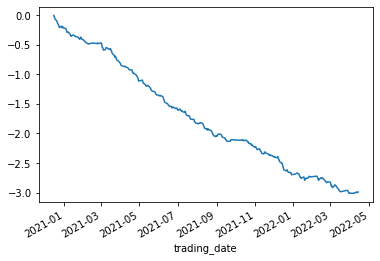

In [25]:
net_s = all_pnl_1d_df.mul(portfolio_weight_s).sum(axis=1)
net_s.cumsum().plot()